In [77]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import json
import mlflow
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [78]:
# Load and prepare data
filepath = "./Data/Processed_dataset.csv"  # Change to the correct file path
df = pd.read_csv(filepath)
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)

df

,ID,mean,std,max,min,p2p,rms,lat,long,size,...,ENERGY_DETAIL,ENTROPY_APPROXIMATION,ENTROPY_DETAIL,MAX_APPROXIMATION,MAX_DETAIL,MIN_APPROXIMATION,MIN_DETAIL,VARIANCE_APPROXIMATION,VARIANCE_DETAIL,label
0,2.0,5.125000,0.000000e+00,5.125000,5.125000,0.000000,5.125000,37.961787,23.751396,79.0,...,0.000000,-1242.665556,-0.0,7.247845,0.000000,7.247845,0.000000,3.155444e-30,0.000000,5.404959
1,4.0,4.809129,4.074345e-01,5.214876,4.400000,0.814876,4.826357,38.002447,23.733089,98.0,...,0.000000,-2281.533650,-0.0,7.374948,0.000000,6.222540,0.000000,3.319888e-01,0.000000,6.295082
2,5.0,0.758333,2.220446e-16,0.758333,0.758333,0.000000,0.758333,38.010464,23.700732,44.0,...,0.000000,-6.492844,-0.0,1.072445,0.000000,1.072445,0.000000,0.000000e+00,0.000000,0.075000
3,6.0,10.771350,3.419571e+00,15.300000,7.024390,8.275610,11.301126,39.074208,21.824312,53.0,...,34.242858,-11108.654733,NaN,21.637468,0.000000,9.933988,-5.851740,2.324691e+01,0.187114,9.975410
4,7.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,39.074208,21.824312,52.0,...,0.000000,-0.000000,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.648352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781,1996.0,13.468880,3.570313e+00,16.677966,4.645161,12.032805,13.934054,39.762755,19.818698,50.0,...,72.394196,-9942.186235,NaN,23.586206,0.000000,6.569250,-8.508478,2.479110e+01,0.593355,14.175824
1782,1997.0,6.346056,4.765276e+00,18.266667,1.900000,16.366667,7.936012,39.762755,19.818698,116.0,...,196.667823,-6263.859908,NaN,25.832968,10.361775,2.687006,-7.168390,4.443316e+01,0.998269,21.290323
1783,1998.0,0.120833,7.916667e-02,0.200000,0.041667,0.158333,0.144458,39.762755,19.818698,129.0,...,0.000000,45.361668,-0.0,0.282843,0.000000,0.058926,0.000000,1.253472e-02,0.000000,0.243902
1784,1999.0,5.315353,6.708964e-01,5.983471,4.641667,1.341804,5.357525,39.762755,19.818698,35.0,...,0.000000,-2659.515236,-0.0,8.461906,0.000000,6.564308,0.000000,9.001580e-01,0.000000,3.106557


In [79]:
# Split dataset into train, validation, and test sets
train_len = 0.7
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_len, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [80]:
# Standardization using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Create a folder named "scalers" if it doesn't exist
scaler_dir = "scalers"
os.makedirs(scaler_dir, exist_ok=True)

# Save the feature scaler
joblib.dump(scaler_X, os.path.join(scaler_dir, 'scaler_X.pkl'))

# Save the target scaler
joblib.dump(scaler_y, os.path.join(scaler_dir, 'scaler_y.pkl'))

['scalers\\scaler_y.pkl']

In [81]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

class XGBoostModel:
    def __init__(self, n_estimators, learning_rate, early_stopping_rounds, max_depth):
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            early_stopping_rounds=early_stopping_rounds,
            max_depth=max_depth,
            n_jobs=-1
        )
        self.eval_results = None  # To store evaluation results

    def train(self, X_train, y_train, X_val, y_val):
        print('Starting XGBoost training...')
        self.model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=None)
        # self.eval_results = self.model.evals_result()

    def predict(self, X):
        return self.model.predict(X)

    def save_model(self, file_path):
        self.model.save_model(file_path)

    @staticmethod
    def load_model(file_path):
        model = xgb.XGBRegressor() 
        model.load_model(file_path)
        return model

    def plot_learning_curve(self):
        """Plot the training and validation loss curves."""
        if self.eval_results is None:
            print("No evaluation results to plot. Train the model first.")
            return
        train_rmse = self.eval_results['train']['rmse']
        val_rmse = self.eval_results['validation']['rmse']
        plt.figure(figsize=(10, 6))
        plt.plot(train_rmse, label='Train RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.xlabel('Number of Trees')
        plt.ylabel('RMSE')
        plt.title('Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.show()


In [82]:
def tune_xgboost(n_trials):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)
        }
        model = XGBoostModel(**params)
        model.train(X_train_scaled,y_train_scaled,X_val_scaled,y_val_scaled)
        predictions = model.predict(X_val)
        
        return mean_absolute_percentage_error(y_val, predictions)
    
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    print(f"Best params for XGBoost: {study.best_params}")
    return study.best_params


In [83]:
best_params = tune_xgboost(n_trials=1)

with open('best_params_tuned.json', 'w') as f:
    json.dump(obj=best_params, fp=f, indent=4)

[I 2025-01-30 17:08:10,414] A new study created in memory with name: no-name-75f7f86d-31bc-4f88-9cd3-0eb00c7407c4


Starting XGBoost training...


[I 2025-01-30 17:08:11,182] Trial 0 finished with value: 0.8897695146687383 and parameters: {'n_estimators': 3972, 'learning_rate': 0.18899545799719528, 'max_depth': 12, 'early_stopping_rounds': 50}. Best is trial 0 with value: 0.8897695146687383.


Best params for XGBoost: {'n_estimators': 3972, 'learning_rate': 0.18899545799719528, 'max_depth': 12, 'early_stopping_rounds': 50}


In [84]:
# # Set the new experiment
# # mlflow.set_experiment(experiment_name)
# os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
# os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
# os.environ['AWS_ACCESS_KEY_ID']='super'
# os.environ['AWS_SECRET_ACCESS_KEY']='supersecret'
# os.environ['MLFLOW_S3_ENDPOINT_URL']='https://minio.sedimark.work'
# os.environ['MLFLOW_TRACKING_INSECURE_TLS']='true'


# # Set the specific tracking URI (MLflow server URL)
# mlflow.set_tracking_uri("https://mlflow.sedimark.work/")
# # mlflow.xgboost.autolog()

# # Create a new experiment
# experiment_name = "XGBoost_energy_consumption"
# current_experiment = mlflow.get_experiment_by_name(experiment_name)

# if current_experiment is None:    
#     experiment_id = mlflow.create_experiment(experiment_name)    
#     current_experiment = mlflow.get_experiment(experiment_id)

# # End any active run
# if mlflow.active_run():
#     mlflow.end_run()
    
# with mlflow.start_run(experiment_id=current_experiment.experiment_id):
#     # Instantiate, train, and evaluate the model
#     xgb_model = XGBoostModel(**best_params)
#     # Train the model
#     xgb_model.train(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)

#     # Make predictions
#     y_train_pred = xgb_model.predict(X_train_scaled)
#     y_val_pred = xgb_model.predict(X_val_scaled)

#     # Calculate metrics for train set
#     mse = mean_squared_error(y_train_scaled, y_train_pred)
#     rmse = root_mean_squared_error(y_train_scaled, y_train_pred)
#     r2 = r2_score(y_train_scaled, y_train_pred)
#     mae = mean_absolute_error(y_train_scaled, y_train_pred)
#     mape = (abs((y_train_scaled - y_val_pred) / y_train_scaled).mean()) * 100

#     # Log the calculated metrics to MLflow
#     mlflow.log_metric("Train MSE", mse)
#     mlflow.log_metric("Train RMSE", rmse)
#     mlflow.log_metric("Train R2", r2)
#     mlflow.log_metric("Train MAE", mae)

#     # Calculate metrics for validation set
#     mse = mean_squared_error(y_val_scaled, y_val_pred)
#     rmse = root_mean_squared_error(y_val_scaled, y_val_pred)
#     r2 = r2_score(y_val_scaled, y_val_pred)
#     mae = mean_absolute_error(y_val_scaled, y_val_pred)
#     mape = (abs((y_val_scaled - y_val_pred) / y_val_scaled).mean()) * 100

#     # Log the calculated metrics to MLflow
#     mlflow.log_metric("Validation MSE", mse)
#     mlflow.log_metric("Validation RMSE", rmse)
#     mlflow.log_metric("Validation R2", r2)
#     mlflow.log_metric("Validation MAE", mae)
#     mlflow.log_metric("Validation MAPE", mape)

#     mlflow.xgboost.log_model(xgb_model, artifact_path="model")

In [85]:
# Instantiate, train, and evaluate the model
xgb_model = XGBoostModel(**best_params)
# Train the model
xgb_model.train(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)

# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)

# Calculate metrics for train set
mse = mean_squared_error(y_train_scaled, y_train_pred)
rmse = root_mean_squared_error(y_train_scaled, y_train_pred)
r2 = r2_score(y_train_scaled, y_train_pred)
mae = mean_absolute_error(y_train_scaled, y_train_pred)
mape = (abs((y_train_scaled - y_val_pred) / y_train_scaled).mean()) * 100


# Calculate metrics for validation set
mse = mean_squared_error(y_val_scaled, y_val_pred)
rmse = root_mean_squared_error(y_val_scaled, y_val_pred)
r2 = r2_score(y_val_scaled, y_val_pred)
mae = mean_absolute_error(y_val_scaled, y_val_pred)
mape = (abs((y_val_scaled - y_val_pred) / y_val_scaled).mean()) * 100


# Plot the learning curve
xgb_model.plot_learning_curve()

# Make predictions on the test set
predictions = xgb_model.predict(X_test_scaled)

# Inverse transform the predictions and actual values back to the original scale
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_actual, predictions)
rmse = root_mean_squared_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
mape = mean_absolute_percentage_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Save the model
xgb_model.save_model("models/xgb_model.json")

Starting XGBoost training...
No evaluation results to plot. Train the model first.
Mean Absolute Error (MAE): 3.4921
Mean Squared Error (MSE): 32.1597
Root Mean Squared Error (RMSE): 5.6710
Mean Absolute Percentage Error (MAPE): 8.9928
R^2 Score: 0.2292


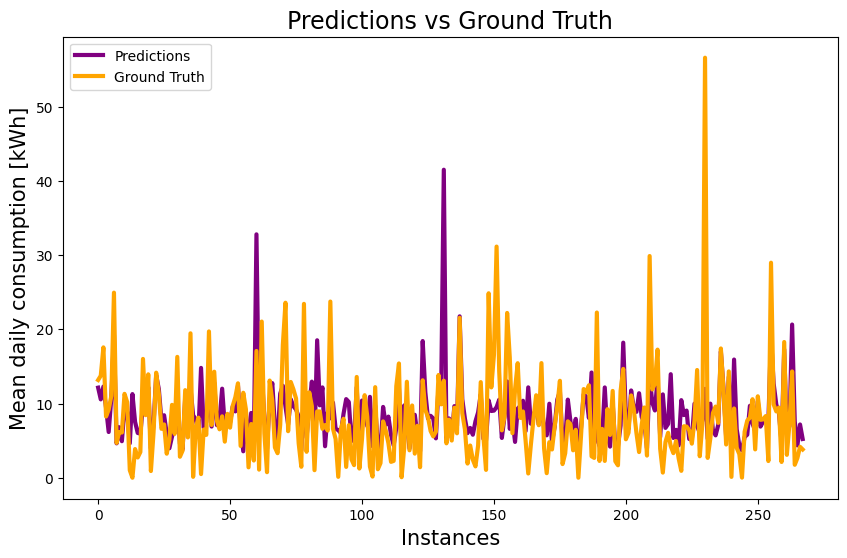

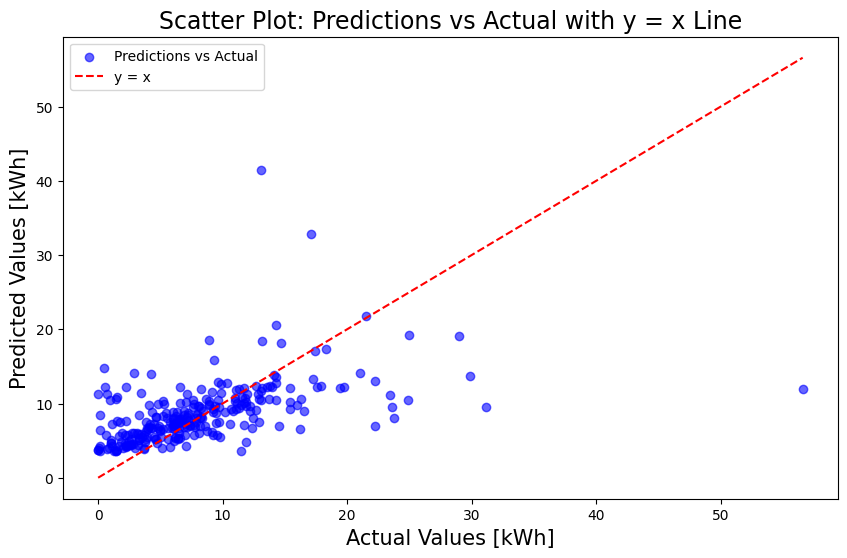

In [86]:
# Load the model
loaded_model = XGBoostModel.load_model("models/xgb_model.json")
loaded_predictions = loaded_model.predict(X_test_scaled)

# Inverse transform the loaded predictions back to original scale
loaded_predictions = scaler_y.inverse_transform(loaded_predictions.reshape(-1, 1))

# Plot the predictions vs actual values
plt.figure(figsize=(10,6))
plt.plot(loaded_predictions, label="Predictions", linewidth=3, color='purple')
plt.plot(y_test_actual, label="Ground Truth", linewidth=3, color='orange')
plt.xlabel('Instances', fontsize=15)
plt.ylabel('Mean daily consumption [kWh]', fontsize=15)
plt.legend()
plt.title('Predictions vs Ground Truth', fontsize=17)
plt.show()

# Scatter plot between predictions and actual values
plt.figure(figsize=(10,6))
plt.scatter(y_test_actual, loaded_predictions, alpha=0.6, color='b', label='Predictions vs Actual')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='r', linestyle='--', label='y = x')
plt.xlabel('Actual Values [kWh]', fontsize=15)
plt.ylabel('Predicted Values [kWh]', fontsize=15)
plt.title('Scatter Plot: Predictions vs Actual with y = x Line', fontsize=17)
plt.legend()
plt.show()